%md

#  Exploratory Data Analysis on StudentsPerformance Dataset

This notebook performs an in-depth exploratory data analysis (EDA) on student performance data.  
The goal is to uncover patterns, trends, and correlations between student attributes and their academic scores in math, reading, and writing.


Load Libraries and Dataset

In [0]:
# PySpark and plotting libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, when, count
import pandas as pd
import matplotlib.pyplot as plt

# Create Spark session (automatically available in Databricks)
spark = SparkSession.builder.getOrCreate()

# Load CSV into DataFrame
file_path = "/Volumes/hexaware_databricks/default/file/StudentsPerformance.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(file_path)

# Preview the data
df.show(5)

+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|female|       group B|          bachelor's degree|    standard|                   none|        72|           72|           74|
|female|       group C|               some college|    standard|              completed|        69|           90|           88|
|female|       group B|            master's degree|    standard|                   none|        90|           95|           93|
|  male|       group A|         associate's degree|free/reduced|                   none|        47|           57|           44|
|  male|       group C|               some college|    standard|                   none|        76|     

Data Overview

In [0]:
# Schema
df.printSchema()

# Total number of rows
print("Total Rows:", df.count())

# Summary statistics
df.describe().show()

root
 |-- gender: string (nullable = true)
 |-- race/ethnicity: string (nullable = true)
 |-- parental level of education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test preparation course: string (nullable = true)
 |-- math score: integer (nullable = true)
 |-- reading score: integer (nullable = true)
 |-- writing score: integer (nullable = true)

Total Rows: 1000
+-------+------+--------------+---------------------------+------------+-----------------------+------------------+------------------+-----------------+
|summary|gender|race/ethnicity|parental level of education|       lunch|test preparation course|        math score|     reading score|    writing score|
+-------+------+--------------+---------------------------+------------+-----------------------+------------------+------------------+-----------------+
|  count|  1000|          1000|                       1000|        1000|                   1000|              1000|              1000|             1

Check for Missing Values

In [0]:
# Count nulls in each column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|     0|             0|                          0|    0|                      0|         0|            0|            0|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+



Unique Values per Column

In [0]:
for column in df.columns:
    print(f"{column}: {df.select(column).distinct().count()} unique values")

gender: 2 unique values
race/ethnicity: 5 unique values
parental level of education: 6 unique values
lunch: 2 unique values
test preparation course: 2 unique values
math score: 81 unique values
reading score: 72 unique values
writing score: 77 unique values


Score Distribution Analysis

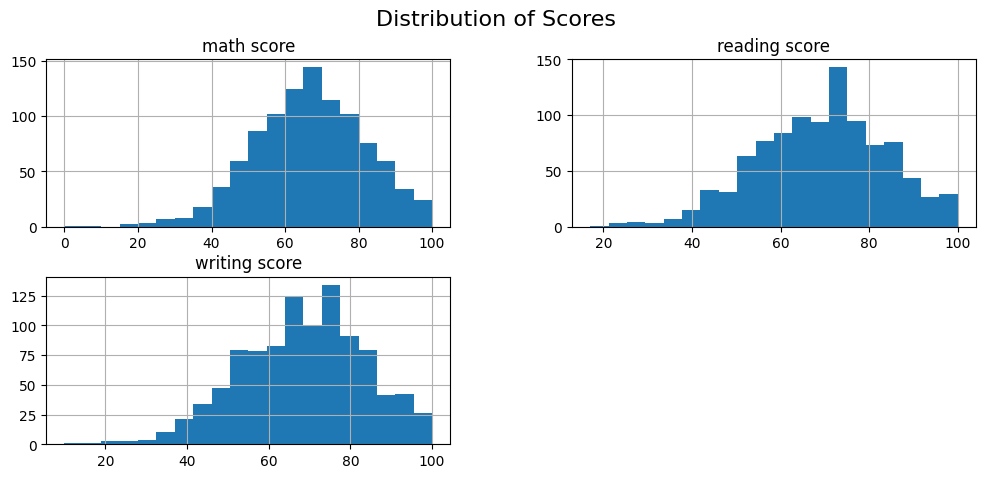

In [0]:
# Convert to pandas for easy plotting
pdf = df.select("math score", "reading score", "writing score").toPandas()

# Plot histograms
pdf.hist(figsize=(12, 5), bins=20)
plt.suptitle("Distribution of Scores", fontsize=16)
plt.show()

Gender-wise Average Scores

In [0]:
# Average score per gender
df.groupBy("gender").agg(
    mean("math score").alias("Avg Math"),
    mean("reading score").alias("Avg Reading"),
    mean("writing score").alias("Avg Writing")
).show()

+------+------------------+-----------------+-----------------+
|gender|          Avg Math|      Avg Reading|      Avg Writing|
+------+------------------+-----------------+-----------------+
|female|63.633204633204635|72.60810810810811|72.46718146718146|
|  male| 68.72821576763485|65.47302904564316|63.31120331950208|
+------+------------------+-----------------+-----------------+



Visualization: Gender-wise Average Scores

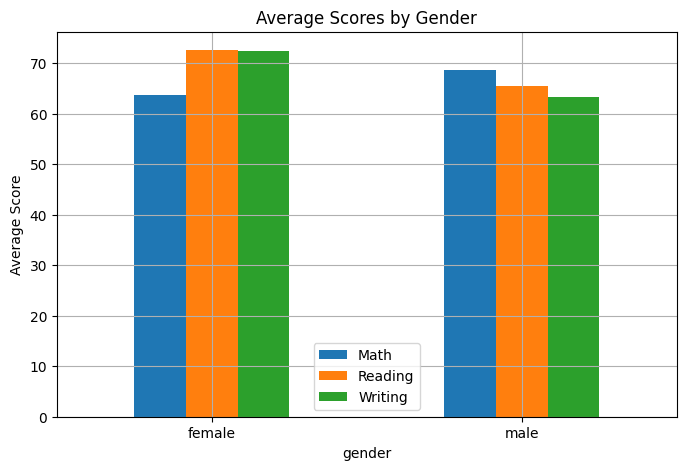

In [0]:
# Visualization (using Pandas + Matplotlib)
gender_scores = df.groupBy("gender").agg(
    mean("math score").alias("Math"),
    mean("reading score").alias("Reading"),
    mean("writing score").alias("Writing")
).toPandas().set_index("gender")

gender_scores.plot(kind="bar", figsize=(8, 5))
plt.title("Average Scores by Gender")
plt.ylabel("Average Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

Score Comparison by Parental Education

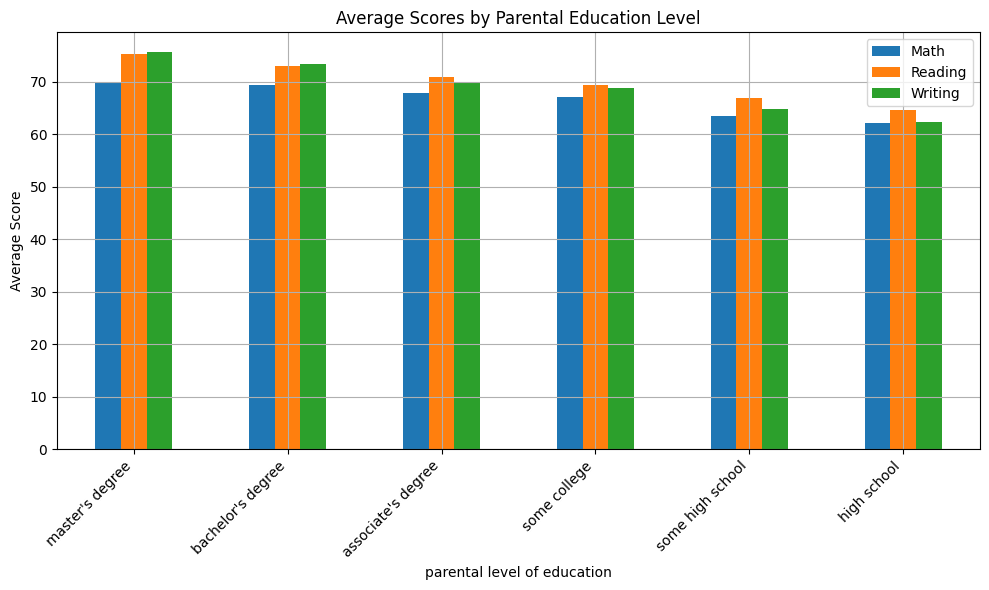

In [0]:
parent_edu_scores = df.groupBy("parental level of education").agg(
    mean("math score").alias("Math"),
    mean("reading score").alias("Reading"),
    mean("writing score").alias("Writing")
).toPandas().set_index("parental level of education").sort_values("Math", ascending=False)

parent_edu_scores.plot(kind="bar", figsize=(10, 6))
plt.title("Average Scores by Parental Education Level")
plt.ylabel("Average Score")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

Effect of Test Preparation Course

In [0]:
df.groupBy("test preparation course").agg(
    mean("math score").alias("Math"),
    mean("reading score").alias("Reading"),
    mean("writing score").alias("Writing")
).show()

+-----------------------+-----------------+-----------------+-----------------+
|test preparation course|             Math|          Reading|          Writing|
+-----------------------+-----------------+-----------------+-----------------+
|              completed|69.69553072625699|73.89385474860335|74.41899441340782|
|                   none| 64.0778816199377|66.53426791277259|64.50467289719626|
+-----------------------+-----------------+-----------------+-----------------+



Correlation Analysis

               math score  reading score  writing score
math score       1.000000       0.817580       0.802642
reading score    0.817580       1.000000       0.954598
writing score    0.802642       0.954598       1.000000


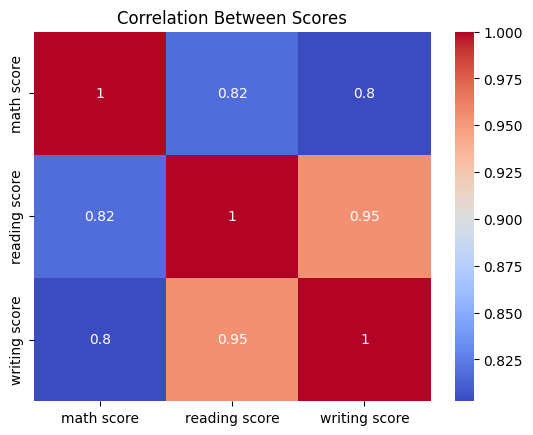

In [0]:
# Correlation between scores
pdf = df.select("math score", "reading score", "writing score").toPandas()
correlation = pdf.corr()
print(correlation)

# Heatmap
import seaborn as sns
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Between Scores")
plt.show()

%md

###  Key Insights

- Female students scored higher on average in reading and writing, while male students slightly outperformed in math.
- Completing a test preparation course significantly improves scores in all subjects.
- Higher parental education level correlates with better student performance.
- There is a strong positive correlation between reading and writing scores.

This analysis can help educators and policy-makers understand which factors influence student success the most.